In [439]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import math

## Part 3 (10 pts.)

Coding and statistical learning go hand-in-hand.  Your previous classes have largely been pen-and-paper focused - even your regression class likely only covered methods that could, in theory, be done with some pen, paper, and a calculator (though inverting a large matrix by hand would be considered cruel and unusual torture by most).  We're going to quickly move out of the realm of methods that are analytically solvable, so understanding how **algorithms** work from the ground up will help you to understand why something works when we can't always prove it via mathematics.  In many cases, too, we'll find that computational approaches with no pen-and-paper analogue (cross-validation, bootstrapping, black-box optimization, etc.) will provide superior answers to the analytical methods.^[Have you ever really thought about how a computer inverts a matrix?  It requires a lot of mathematics that aren't needed when thinking about doing it by hand.  There's tricks and decompositions that make it work almost instantaneously!  This is just one example of a situation where the computational approach is far superior to the analytical one]

This said, let's assume that you didn't know how to find the optimum derived in part 1.  We could always use **numerical optimization** methods to find the minimum.  Additionally, since we can leverage our knowledge that the function is strictly convex in $\alpha$ and $\beta$, we should always land on the same answer!  So, this method will be equivalent.

Write a function called `sse_minimizer` that uses a built-in optimization routine to find the values of $\alpha$ and $\beta$ that minimize the sum of squared errors for simple linear regression.  `sse_minimizer` should take in two arguments: `y` - a $N$-vector of outcome values and `x` - a $N$-vector of predictor values.  It should return a list (or equivalent holder) with five elements elements: 1) `alpha_est` - the value of the intercept given by the optimization routine, 2) `beta_est` - the value of the regression coefficient given by the optimization routine, 3) `alpha_true` - the true value of the intercept computed using your answer from part 1, 4) `beta_true` - the value of the regression coefficient computed using your answer from part 1, and 5) `mse` - the mean squared error (the sum of squared errors divided by the number of observations) between the predicted value of the outcome and the true value of the outcome.

To test your function, generate some simulated data:

  1. Generate 1000 uniform random values between -3 and 3 as `x`
  2. Choose some values for the intercept and slope, `a` and `b`.  Using `x`, generate `y` as `a + b*x`.
  3. Add some random noise to `y` - `y <- y + rnorm(100,0,1)` for example.
  4. Plug `x` and `y` into your function and see if it returns the correct parameter values.
  
A full-credit answer will demonstrate that the function works!

Some tips to help you get going (in R, if that's your choice; Python is similar):

  1. Write a function called `sum_squared_errors` that takes three arguments: 1) `coefficients` - a 2-vector of coefficients ($\alpha$ and $\beta$, respectively, 2) `y` - a $N$-vector of outcome values, and 3) `x` - a $N$-vector of predictor values.  The function should return the sum of squared errors **given** the input values of $\alpha$ and $\beta$.
  
  2. Call `sum_squared_errors` from `sse_minimizer` within the optimization routine.  I recommend using base R's `optim` to find the minimum.  `optim` can be a bit confusing on the first go, so be sure to **read the documentation** and look for examples online if you're confused.  I'm also happy to help in office hours, but I think this is an important "do-it-yourself" technique.
  
  3. Lists are nifty because we can easily name elements.  If we have `lst <- list()`, then we can assign `lst$alpha <- foo` and `lst$beta <- bar`.

In [440]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import math

In [441]:
# Generate data from uniform distribution
np.random.seed(777)
x_train = np.random.uniform(-3, 3, 1000)
alpha_choice = math.pi
beta_choice = math.e
y_train = alpha_choice + beta_choice * x_train + np.random.normal(0, 1, 1000)

In [442]:
def sum_squared_errors(params):
    """
    Function to calculate the sum of squared errors for a simple linear regression model.
    Inputs:
        params: 1D array of weights
    Outputs:
        sse: scalar value of sum of squared errors
    """
    # Get the weights
    w = params
    # Get the X matrix
    X = np.array([np.ones(len(x_train)), x_train]).T
    # Calculate the sum of squared errors
    sse = np.sum(np.square(X.dot(w) - y_train))
    return sse

def sse_minimizer(y, x):
    """
    Function to find the optimal coefficients for a simple linear regression model.
    Inputs:
        y: 1D array of training data
        x: 1D array of training data
    Outputs:
        w: 1D array of weights
    """
    # Optimization method with scipy.optimize.minimize
    # initialize w
    w = np.array([0, 0])
    opt_result = optimize.minimize(sum_squared_errors, w)
    alpha_est, beta_est = opt_result.x
    beta_true = (sum(x*y)-len(x)*np.mean(x)*np.mean(y))/(sum(x**2)-len(x)*np.mean(x)**2) # from part 1
    alpha_true = np.mean(y)-beta_true*np.mean(x) # from part 1
    return {"alpha_est": alpha_est, "beta_est": beta_est, "alpha_true": alpha_true, "beta_true": beta_true}

sse_minimizer(y_train, x_train)



{'alpha_est': 3.150021400640548,
 'beta_est': 2.728723321003393,
 'alpha_true': 3.1500214119019394,
 'beta_true': 2.728723328567721}

## Part 5 (10 pts.)

Maximum likelihood estimators are an important part of statistics and machine learning as they are commonly used to minimize certain types of **loss functions** - find the parameter that maximizes the likelihood/minimizes the loss with respect to the data generating process.  MLEs are desirable in statistics because they have a number of desirable properties like asymptotic unbiasedness, consistency, and efficiency and follow the same generic recipe regardless of data type.  Asymptotic unbiasedness means that the estimator converges to the correct answer almost surely as $N \rightarrow \infty$. Asymptotic consistency implies that as $N \rightarrow \infty$, the standard deviation of the sampling distribution (e.g. the standard error) goes to zero.  Asymptotic efficiency implies that the estimator achieves the lowest possible variance on the path to zero - otherwise known as the Cramer-Rao lower bound.

For this last part, I want you to graphically show the asymptotic consistency and efficiency properties using a method called **parametric bootstrapping**.  We're going to discuss bootstrapping as a method of uncertainty calculation and this part is a short introduction to the method.  Bootstrapping techniques leverage the fact that probability can be interpreted as the long run proportion of occurrence.  We can replicate long-run frequencies by using computational methods to take random draws from a distribution.

The distribution you've been working with here is called the **exponential distribution** and is a key distribution in the study of random counting processes and Bayesian statistics.  This makes the process of taking **random draws** from the distribution easy - just use `rexp()` in R and the equivalent functions in other languages!  The main gist of bootstrapping is that we can replicate the process of repeated sampling by taking a large number of random draws from the distribution of interest to estimate the quantity of interest.

Write a function called `bootstrap_se` that takes in three arguments: 1) `n` - the sample size, 2) `b` - the number of bootstrap replicates, and 3) `lambda` - a value for $\lambda$.  Your function should do the following:
```{r, eval=FALSE}
For n, b, and lambda
  For i in 1:b
    Draw n values from Exp(lambda)
    Compute MLE for lambda
    Store MLE
  Compute standard deviation of MLEs
  Return standard deviation
```
In words, this function should take $N$ samples from an exponential distribution parameterized by $\lambda$ and compute the MLE implied by your random draws $B$ times.  The standard deviation of these $B$ values converges almost surely to the standard error of the sampling distribution for the MLE which is used to perform inference about the value of the parameter.

Using your function, evaluate the standard deviation of the MLE setting `n` equal to 10,20,30,....,280,290,300, `b` equal to 250, and `lambda` equal to 1/3.  Then, plot the standard deviations against the values of `n` as a line graph.  Label this as the "Bootstrap" line.  Does this line approach 0?  What is approximate rate at which it converges (think in terms of the sample size)?  

To demonstrate that the MLE is maximally efficient (the most efficient estimator possible), compute the Cramer-Rao lower bound for the exponential MLE given a value of $N$.  The Cramer-Rao lower bound, the minimum variance that can be achieved with an asymptotically unbiased estimator of $\lambda$, is shown below:
$$\text{CRLB}[f(X ; \lambda)] = \sqrt{-\left[\frac{\partial^2 \log f(X ; \lambda)}{\partial \lambda \partial \lambda}\right]^{-1}} = \frac{\lambda}{\sqrt{N}}$$
Plot this value against the corresponding values of `n` on the same plot as your bootstrapped line and label this as the "CRLB" line.  Does the bootstrapped MLE standard error reach the Cramer-Rao lower bound?  Generate the same figure for at least 2 other values of $\lambda$.  Does the same relationship hold?  

In [443]:
np.random.seed(1234)
def bootstrap_se(n, b, lambdaValue):
    """
    Function to calculate the standard error of the bootstrap estimate of MLE of exponential distribution.
    Inputs:
        n: scalar value of sample size
        b: scalar value of number of bootstrap samples
        lambdaValue: scalar value of lambda
    Outputs:    
        se: scalar value of standard error
    """
    MLE_list = []
    for i in range(1, b):
        # Generate bootstrap sample
        bootstrap_sample = np.random.exponential(lambdaValue, n)
        # Calculate the MLE of exponential distribution
        mle_lambda = n / sum(bootstrap_sample) # from part 4
        MLE_list.append(mle_lambda)
    # Calculate the standard error
    se = np.std(MLE_list)
    #print("mean:{}, lambda:{}, se:{}, n:{}".format(np.mean(MLE_list), lambdaValue, se, n))
    return se

# dataframe to store the bootstrap standard errors
bootstrap_se_df = pd.DataFrame(columns=["n", "b", "lambdaValue", "se", "CRLB"])
bootstrap_se_df["n"] = np.linspace(10, 300, 30)
bootstrap_se_df["n"] = bootstrap_se_df["n"].astype(int)
bootstrap_se_df["b"] = 250
bootstrap_se_df["b"] = bootstrap_se_df["b"].astype(int)
bootstrap_se_df["lambdaValue"] = bootstrap_se_df.apply(lambda row:[1/3, 1/2, 1, 2, 3, 4], axis=1)
bootstrap_se_df = bootstrap_se_df.explode("lambdaValue")
bootstrap_se_df["se"] = bootstrap_se_df.apply(lambda row: bootstrap_se(row["n"], row["b"], row["lambdaValue"]), axis=1)
bootstrap_se_df["CRLB"] = bootstrap_se_df.apply(lambda row: row["lambdaValue"]/np.sqrt(row["n"]), axis=1)

        

In [444]:
bootstrap_se_df

,n,b,lambdaValue,se,CRLB
0,10,250,0.333333,1.209037,0.105409
0,10,250,0.5,0.777243,0.158114
0,10,250,1,0.428330,0.316228
0,10,250,2,0.220135,0.632456
0,10,250,3,0.133768,0.948683
...,...,...,...,...,...
29,300,250,0.5,0.113979,0.028868
29,300,250,1,0.058220,0.057735
29,300,250,2,0.026532,0.115470
29,300,250,3,0.019834,0.173205


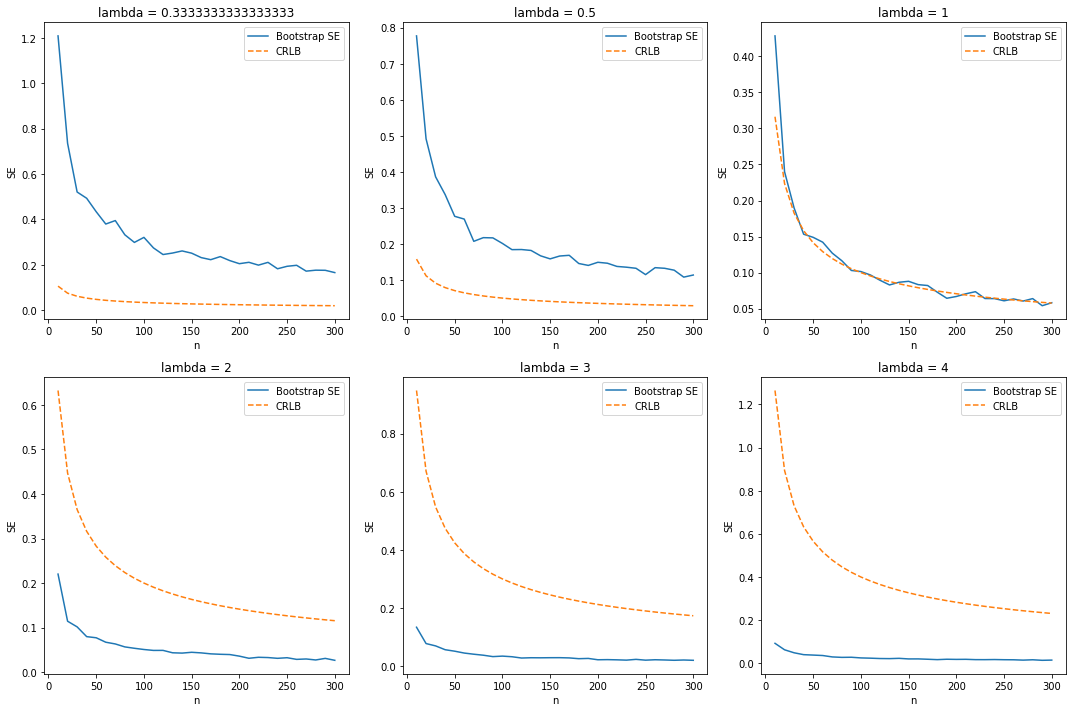

In [445]:
def plot_bootstrap_se(bootstrap_se_df, lambdaValue, subplot_row, subplot_col):
    #subset df
    bootstrap_se_df_sub = bootstrap_se_df[bootstrap_se_df["lambdaValue"] == lambdaValue]
    
    se = bootstrap_se_df_sub["se"]
    crlb = bootstrap_se_df_sub["CRLB"]
    ax[subplot_row, subplot_col].plot(bootstrap_se_df_sub["n"], se, label="Bootstrap SE")
    ax[subplot_row, subplot_col].plot(bootstrap_se_df_sub["n"], crlb, label="CRLB", linestyle="--")
    ax[subplot_row, subplot_col].set_title(f"lambda = {lambdaValue}")
    ax[subplot_row, subplot_col].set_xlabel("n")
    ax[subplot_row, subplot_col].set_ylabel("SE")
    ax[subplot_row, subplot_col].legend()

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
plot_bootstrap_se(bootstrap_se_df, 1/3, 0, 0)
plot_bootstrap_se(bootstrap_se_df, 1/2, 0, 1)
plot_bootstrap_se(bootstrap_se_df, 1, 0, 2)
plot_bootstrap_se(bootstrap_se_df, 2, 1, 0)
plot_bootstrap_se(bootstrap_se_df, 3, 1, 1)
plot_bootstrap_se(bootstrap_se_df, 4, 1, 2)
plt.tight_layout()
plt.show()


Answer:
From the graph, we can see that before $\lambda = 2$, the bootstrap standard error converges to the Cramer-Rao lower bound as the sample size increases.  The bootstrap standard error converges to 0 as the sample size increases.  However, after $\lambda=2$ or greater, the Cramer-rao lower bound is reached, meaning that the MLE is **biased** because the Cramer-Rao lower bound is the minimum variance that can be achieved with an asymptotically unbiased estimator of $\lambda$. <sub><sup>or my derivation of MLE or implementations are wrong</sup></sub>

# Problem 3

For the last part of this problem set, I want you to think about **classification** models.  At their core, classification is a task that seeks to uncover a set of rules that determine whether an observation has or does not have a specific trait - Did the member of Congress cast a "Yes" vote for the bill? Will the customer buy a $2100 phone? Does the patient have cancer?  These are all questions that can addressed using classification models.

We're going to talk about a variety of approaches for building classification models.  However, all methods share a similar core strategy: given a set of predictors, what is a **rule set** that best predicts the observations true class?  For this problem, I want you to try to build a common-sense rules based model that predicts whether or not a patient has heart disease.

## Part 1 (15 pts.)

The data set `heartTrain.csv` contains information about 200 patients that were tested for heart disease.  `AHD` tells whether a patient was diagnosed with heart disease (`AHD` = 1) or not (`AHD` = 0).  There are also five predictors included - 1) `Age` (in years), 2) `Sex` (0 is female, 1 is male), 3) `RestBP` (the patient's resting blood pressure in mm/Hg), 4) `Chol` (the patient's serum cholesterol in mg/dl), and 5) `Slope` (a three category measure of heart responsiveness to exercise (a.k.a. the ST segment) - 1 means that the heart increased activity during exercise, 2 means that the heart activity remained constant, while 3 means that heart activity decreased during exercise).  

Using this data set, write a function called `heartDisease_predict` that takes in values for each of the five predictors and returns a prediction for whether or not the patient has a heart disease.  Then, use your predictive model to assess the **accuracy** of the predictions by comparing them to the real labels.  What proportion are correct?  What proportion are incorrect?

Your predictive model should only use if/else style rules (for example, if `Sex = 0` and `Rest BP < 140` then `AHD = 0`).  You can determine these rules by examining summary statistics, plots, running regression models, etc.  

You'll receive 10 points for the programming of your function and explanation of your approach.  You'll receive 2 more points for this problem if your model gets at least 60% of your predictions are correct, 3 more points pts. for at least 75%, and 5 more points for at least 85%.  If you come up with an approach that gets more than 95% correct, I'll add a bonus point to this assignment.  You can use any combination of predictors, transformations, and approaches to determine the rules set.

In [446]:
train_data = pd.read_csv("heartTrain.csv")

In [447]:
train_data.describe().iloc[[3,-1],:]
age_range = range(29,78)
sx_range = range(0,2)
RestBP_range = range(94,181)
chol_range = range(131,565)
Slope_range = range(1,4)


In [448]:
train_data.query("AHD == 1").describe()

,Age,Sex,RestBP,Chol,Slope,AHD
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.0
mean,56.204301,0.838710,132.806452,245.537634,1.817204,1.0
std,7.860965,0.369792,16.687185,49.784876,0.588776,0.0
min,35.000000,0.000000,100.000000,131.000000,1.000000,1.0
25%,52.000000,1.000000,120.000000,207.000000,1.000000,1.0
50%,58.000000,1.000000,130.000000,243.000000,2.000000,1.0
75%,61.000000,1.000000,140.000000,282.000000,2.000000,1.0
max,77.000000,1.000000,180.000000,407.000000,3.000000,1.0


In [449]:
train_data.query("AHD == 1").describe() - train_data.query("AHD == 0").describe()

,Age,Sex,RestBP,Chol,Slope,AHD
count,-14.000000,-14.000000,-14.000000,-14.000000,-14.000000,-14.0
mean,3.372525,0.268616,4.105517,1.388102,0.359260,1.0
std,-1.949009,-0.127600,0.559618,-7.836989,-0.014366,0.0
min,6.000000,0.000000,6.000000,-10.000000,0.000000,1.0
25%,8.000000,1.000000,2.000000,-1.500000,0.000000,1.0
50%,5.000000,0.000000,0.000000,9.000000,1.000000,1.0
75%,0.500000,0.000000,0.000000,13.500000,0.000000,1.0
max,3.000000,0.000000,2.000000,-157.000000,0.000000,1.0


In [450]:
def predict(Slope, Age, Sex, RestBP, Chol):
    if Slope <= 1.5:
        if Age <= 56.5:
            if Sex < 1:
                return 0
            else:
                if Age <= 52.5:
                    if Chol <= 222.5:
                        return 0
                    else:
                        if Age <= 45.5:
                            if RestBP <= 146.0:
                                return 0
                            else:
                                return 1
                        else:
                            return 1
                else:
                    return 0
        else:
            if Sex < 1:
                if Age <= 61.5:
                    return 0
                else:
                    return 0
            else:
                if RestBP <= 155.0:
                    if Chol <= 222.5:
                        if Age <= 58.5:
                            return 0
                        else:
                            return 1
                    else:
                        return 1
                else:
                    return 0
    else:
        if Sex < 1:
            if RestBP <= 148.0:
                if RestBP <= 123.0:
                    return 0
                else:
                    if Age <= 56.5:
                        if RestBP <= 133.0:
                            return 1
                        else:
                            return 0
                    else:
                        if Age <= 63.5:
                            if Chol <= 350.5:
                                return 1
                            else:
                                return 0
                        else:
                            return 0
            else:
                return 1
        else:
            if Chol <= 185.5:
                return 1
            else:
                if Chol <= 245.5:
                    if Chol <= 233.5:
                        if RestBP <= 111.0:
                            return 0
                        else:
                            return 1
                    else:
                        return 0
                else:
                    return 1
          

# accuracy in train_data
train_data_copy = train_data.copy()
train_data_copy["prediction"] = train_data_copy.apply(lambda row: predict(row["Slope"],
 row["Age"], row["Sex"], row["RestBP"], row["Chol"]), axis=1)
train_data_copy["prediction"] = train_data_copy["prediction"].astype(int)
# accuracy in train
sum((train_data_copy["prediction"] == train_data_copy["AHD"]).astype(int))/len(train_data_copy)


0.87

Accuracy on the training set: 87%
The intuition of this model is based on summary statistics of the training set (AHD = 1 or AHD = 0), with the help of a logistic regression model that pinpointed the features that best predict the AHD label.

In [451]:
#def accuracy(w, AHD_PREDICTED, AHD_TRUE):
#    num_correct = 0
#    w_age, w_chol, w_sx, w_restBP, w_slope = w
#    print(w_age, w_chol, w_sx, w_restBP, w_slope)
    # simplistic decision tree based on w
    # update AHD_PREDICTED
#    for i in range(len(AHD_TRUE)):
#        if w_sx > train_data['Sex']:
#            if w_sx > 
    # calculate accuracy
#    for i in range(len(AHD_TRUE)):
#        if AHD_PREDICTED[i] == AHD_TRUE[i]:
#            num_correct += 1
#    accuracy = num_correct / len(AHD_TRUE)
    #print("accuracy:", accuracy)
#    return -num_correct/len(AHD_TRUE)

#

#accuracy_df = pd.DataFrame(columns=["age", "chol", "Sex", "RestBP", "Slope", "accuracy"])

#def naive_model(train_data):
#    age = train_data["Age"]
#    chol = train_data["Chol"]
#    Sex = train_data["Sex"]
#    restBP = train_data["RestBP"]
#    slope = train_data['Slope']
#    AHD_TRUE = train_data['AHD']
#    AHD_PREDICTED = np.zeros(len(AHD_TRUE))

#    w = np.array([56, 0, 0, 0, 0])
#    # brute force search
#    for i in age_range:
#        for j in chol_range:
#            j += 50
#            for k in sx_range:
#                for l in RestBP_range:
#                    l += 20
#                    for m in Slope_range:
#                        w[0] = i
#                        w[1] = j
#                        w[2] = k
#                        w[3] = l
#                        w[4] = m
#                        accuracy_df.loc[len(accuracy_df)] = [i, j, k, l, m, accuracy(w, AHD_PREDICTED, AHD_TRUE)]
#    accuracy_df.sort_values(by="accuracy", ascending=False)
    #print(accuracy_df)
#    return w

#naive_model(train_data)


                
        



## Part 2 (5 pts.)

There is a second data set, `heartTest.csv`, that includes more observations from the original data set.  Using your version of `heartDisease_predict`, create predictions for this second data set.  What is the predictive accuracy for the test data set?  Is it better or worse than the accuracy for the training set?  Provide some intuition for this result.

In [452]:
test_set = pd.read_csv("heartTest.csv")
test_set["prediction"] = test_set.apply(lambda row: predict(row["Slope"], row["Age"], row["Sex"], row["RestBP"], row["Chol"]), axis=1)
test_set["prediction"] = test_set["prediction"].astype(int)
# accuracy in train
sum((test_set["prediction"] == test_set["AHD"]).astype(int))/len(test_set)

0.6804123711340206

The accuracy for the test set is 68%, which is worse than the accuracy for the training set. This is not surprising because we must have overfitted our model to the training set. According to the bias-variance tradeoff, the model captures the noise in the training set, and therefore increases the bias of the model.